## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [18]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [19]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [20]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

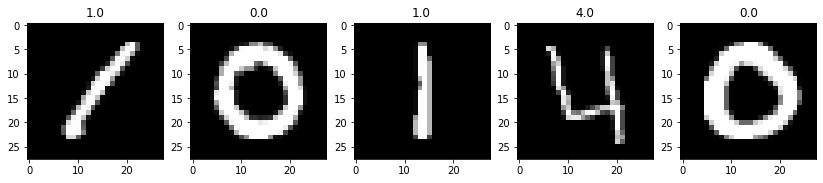

In [21]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# HOG

## Задаем параметры для вычисления дескриптора

In [22]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

## Вычисляем дескриптор для изображения

In [23]:
descriptor_train = hog.compute(np.uint8(train_img[0]))
print('Descriptor size: %d' % len(descriptor_train))

Descriptor size: 144


In [24]:
descriptor_test = hog.compute(np.uint8(test_img[0]))
print('Descriptor size: %d' % len(descriptor_test))

Descriptor size: 144


In [25]:
# descriptors = np.zeros(144).astype(np.float32)
# for i in range(train_img.shape[0]):
#     descriptor = hog.compute(np.uint8(train_img[i])).reshape(-1).astype(np.float32)
#     if i == 0:
#         descriptors = descriptor
#     else:
#         descriptors = np.concatenate((descriptors, descriptor), axis=0)
# #     if i > 5:
# #         break
#     output = descriptors.reshape(-1,144)

In [26]:
def compute_hog_descriptor_for_images(images_array):  
    descriptors = np.zeros(144).astype(np.float32)
    
    for i in range(images_array.shape[0]):
        descriptor = hog.compute(np.uint8(images_array[i])).reshape(-1).astype(np.float32)
        if i == 0:
            descriptors = descriptor
        else:
            descriptors = np.concatenate((descriptors, descriptor), axis=0)
        
    output = descriptors.reshape(-1,144)
    return output

In [27]:
train_descriptors = compute_hog_descriptor_for_images(train_img)
test_descriptors = compute_hog_descriptor_for_images(test_img)

## Разбиваем выборку на обучение и валидацию

In [28]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_descriptors, test_size=0.2,
    random_state=42)

In [29]:
test_descriptors.shape

(28000, 144)

## LogisticRegressionClassifier

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr = LogisticRegression(solver = 'lbfgs', n_jobs=-1)

In [33]:
lr.fit(x_train,y_train)

LogisticRegression(n_jobs=-1)

In [34]:
predictions = lr.predict(x_val)

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predictions)

0.9663095238095238

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       816
         1.0       0.98      0.99      0.98       909
         2.0       0.96      0.96      0.96       846
         3.0       0.97      0.96      0.97       937
         4.0       0.98      0.96      0.97       839
         5.0       0.98      0.97      0.97       702
         6.0       0.97      0.99      0.98       785
         7.0       0.96      0.95      0.96       893
         8.0       0.93      0.94      0.94       835
         9.0       0.95      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, predictions))

[[804   2   4   1   0   0   3   1   1   0]
 [  0 898   3   1   0   0   0   2   5   0]
 [  1   6 815   6   2   1   0   5   9   1]
 [  2   0   5 901   0   6   0   7  14   2]
 [  0   0   2   0 807   0   6   4   7  13]
 [  1   1   1   5   1 678   7   0   7   1]
 [  2   2   0   0   1   1 776   0   3   0]
 [  2   1   9   2   4   1   0 850   3  21]
 [  9   4   5  11   3   2   5   4 786   6]
 [  6   1   1   3   6   0   0  12   7 802]]


## Оцениваем качество решение на валидационной выборке

In [38]:
predictions_final = lr.predict(test_descriptors).astype(int)

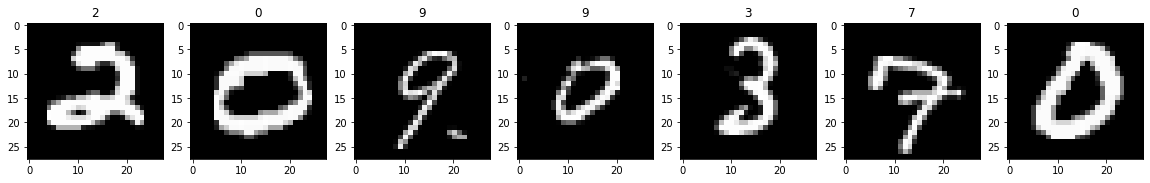

In [39]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predictions_final[i - 1]);

## Готовим файл для отправки

In [40]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predictions_final.astype(int), 1):
        dst.write('%s,%s\n' % (i, p))